## Importing Libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error

import warnings
warnings.filterwarnings('ignore')

## Importing Data

In [21]:
# List of filenames containing our FOREX data
forex_tables_glob = glob("../data/*.xls")

def create_forex_df(all_files_glob=glob("../data/*.xls")):

    all_files = all_files_glob

    li = []

    for filename in all_files:
        tdf = pd.read_excel(filename, skiprows=5, na_values=['CLOSED', 'closed', 'Closed', ' --']).drop([0,1,2,3,4])
        tdf = tdf.rename(columns={'Units':'Date'})

        # Convert Date to Datetime type
        tdf['Date'] = pd.to_datetime(tdf['Date'])

        # Create time series index
        tdf = tdf.set_index('Date', drop=True)
        li.append(tdf)

    df = pd.concat(li, axis=0, sort=False)
    
    return df

data = create_forex_df(forex_tables_glob).astype('float')

## Train, Validation, Test Split

Train Data : 2017 to 2018\
Validation Data : 2019\
Test Data : Jan 2020 to Feb 2020

In [22]:
# Data after 2017 (past 3 years)
data_3yrs = data['2017':]
df = data_3yrs[['USD']]

print("Total data count = ", df.shape[0])
print("Number of missing values = ", df.isnull().sum().sum())
print()

for i in range(1, 11):
    label = "lag_{}".format(i)
    df[label] = df['USD'].shift(i)
    
df = df.dropna(axis=0)

train_df = df['2017':'2018']
val_df = df['2019']
test_df = df['2020']

print("Count of dates in training data = ", train_df.shape[0])
print("Count of dates in validation data = ", val_df.shape[0])
print("Count of dates in test data = ", test_df.shape[0])

Total data count =  778
Number of missing values =  0

Count of dates in training data =  491
Count of dates in validation data =  251
Count of dates in test data =  26


#### Plot AUD/USD training data

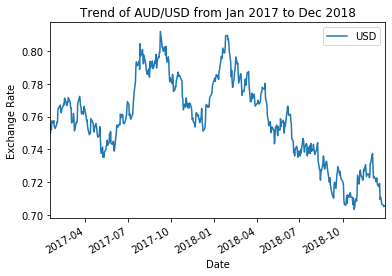

In [23]:
train_rate = train_df[['USD']]
train_rate.plot()
plt.ylabel("Exchange Rate")
plt.title("Trend of AUD/USD from Jan 2017 to Dec 2018")
plt.show()

## Make Time Series stationary 

**Using First Difference transformation**

We will use first difference transformation to make the time series stationary. This is because it had the best stationarity metrics (lowest p-value and ADF Statistic) compared to the below transformations when it was put through the Augmented Dicky Fuller Test for stationarity.

**1. ADFuller with Log Transform**\
**2. ADFuller with Square Root Transform**\
**3. ADFuller with Proportional Change Transformation**\
**4. ADFuller with Log Returns**

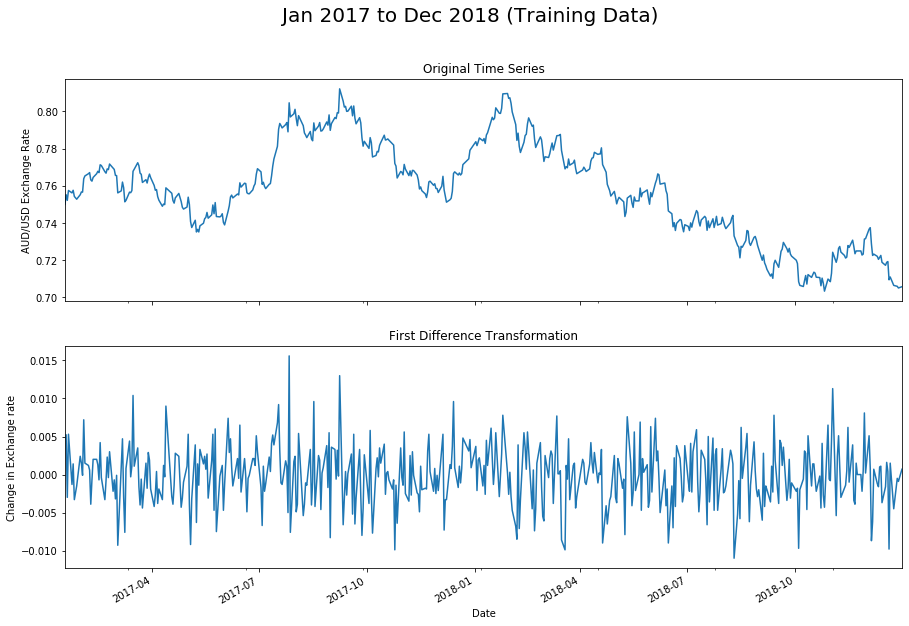

In [35]:
# Transform the train rate using the first difference
train_rate = train_df[['USD']]
train_rate['first_diff'] = train_rate.diff()

fig, (ax1,ax2) = plt.subplots(2, figsize=(15,10), sharex=True)
fig.suptitle('Jan 2017 to Dec 2018 (Training Data)', fontsize=20)

train_rate['USD'].plot(ax=ax1, legend=False)
ax1.set_ylabel("AUD/USD Exchange Rate")
ax1.set_title("Original Time Series")

train_rate['first_diff'].plot(ax=ax2, legend=False)
ax2.set_ylabel("Change in Exchange rate")
ax2.set_title("First Difference Transformation")


plt.show()

## Create 10 Lag features of the transformed data

In [38]:
# first_diff_df = first_diff
# # # Create lag 10 features
# # for i in range(1, 11):
# #     label = "lag_{}".format(i)
# #     first_diff_df[label] = first_diff_df['USD'].shift(i)

train_rate.head(15)

,USD,first_diff
Date,,
2017-01-17,0.7500,NaN
2017-01-18,0.7552,0.0052
2017-01-19,0.7522,-0.0030
2017-01-20,0.7575,0.0053
2017-01-23,0.7562,-0.0013
2017-01-24,0.7576,0.0014
2017-01-25,0.7543,-0.0033
2017-01-27,0.7528,-0.0015
2017-01-30,0.7552,0.0024


**Step 1. Handle null values**

1. The most accurate way to fill missing values, in our case, is to use **the actual data** that we have from the past. *We will come to this later.*

**OR**

2. Drop the missing values.

**Step 2. Split into features(X) and Target(y)**

**Step 3. Visualize features and target**

In [ ]:
tra

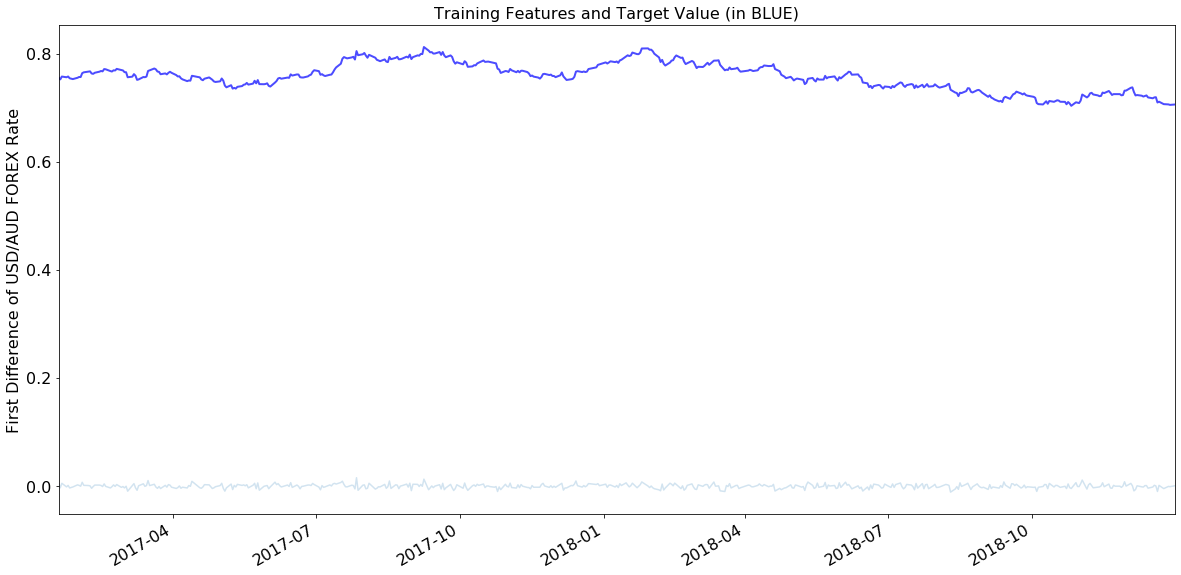

In [41]:
# Step 1
train_rate = train_rate.dropna()

# Step 2
X_train = train_rate['first_diff']
y_train = train_rate['USD']

# Step 3
X_train.plot(figsize=(20,10), alpha=0.2, legend=False, fontsize=16)
y_train.plot(color='blue', linewidth=2, alpha=0.7)
plt.title("Training Features and Target Value (in BLUE)", fontsize=16)
plt.ylabel("First Difference of USD/AUD FOREX Rate", fontsize=16)
plt.xlabel("")
plt.show()

## Create models

- LinearRegression 
- MLPRegressor
- Ridge
- DecisionTreeRegressor
- XGBRegressor
- RandomForestRegressor
- KNeighborsRegressor
- XGBRFRegressor
- Lasso

In [27]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, XGBRFRegressor

In [28]:
labels = ['LinearRegression',
          'Lasso',
          'Ridge',
          'DecisionTreeRegressor',
          'KNeighborsRegressor',
          'MLPRegressor',
          'RandomForestRegressor',
          'XGBRegressor',
          'XGBRFRegressor',
         ]

models = [LinearRegression(),
          Lasso(),
          Ridge(),
          DecisionTreeRegressor(),
          KNeighborsRegressor(),
          MLPRegressor(),
          RandomForestRegressor(),
          XGBRegressor(objective='reg:squarederror'),
          XGBRFRegressor(objective='reg:squarederror')]

In [29]:
def pred_plot(model, label):
    
    results = []
    
    model.fit(X_train, y_train)
#     X_test = test_df.drop('USD', axis=1).astype('float')
#     y_test = test_df['USD']
#     test_pred = model.predict(X_test)
    preds = model.predict(X_train)
    
    plt.plot(y_train, color='blue', label='Actual')
    plt.plot(y_train.index, preds, color='red', label='Predictions')
    plt.title(label)
    plt.legend()
    plt.show()
    
    metrics = [r2_score, mean_absolute_error, mean_squared_error, median_absolute_error]
    metric_labels = ['r2_score', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error']
    
    for metric, label in zip(metrics, metric_labels):
        results.append(metric(y_train, preds))
        
    return results

In [30]:
def evaluate_models(models, labels):
    
    metrics = ['r2_score',
               'mean_absolute_error',
               'mean_squared_error',
               'median_absolute_error']
    
    res = pd.DataFrame(index=labels, columns=metrics)

    for model, label in zip(models, labels):
        eval_metrics = pred_plot(model, label)
        res.at[label,:] = eval_metrics
        
    return res.sort_values(by=metrics, ascending=False)

In [31]:
evaluate_models(models, labels)

NameError: name 'X_train' is not defined

#### Inspect top 3 results

- Decision Tree Regressor
- Random Forest Regressor
- XGB Regressor

In [ ]:
# Transform test data for predictions
test_first_diff_df = test_df.diff().dropna()
X_test = test_first_diff_df.drop('USD', axis=1)
y_test = test_first_diff_df['USD']

In [18]:
def pred_plot(model, label):
    
    results = []
    
    model.fit(X_train, y_train)
    # Transform test data for predictions
    test_first_diff_df = test_df.diff().dropna()
    X_test = test_first_diff_df.drop('USD', axis=1)
    y_test = test_first_diff_df['USD']
    
#  test_pred = model.predict(X_test)
    preds = model.predict(X_test)
    
    plt.plot(y_test, color='blue', label='Actual')
    plt.plot(y_test.index, preds, color='red', label='Predictions')
    plt.title(label)
    plt.legend()
    plt.show()
    
    metrics = [r2_score, mean_absolute_error, mean_squared_error, median_absolute_error]
    metric_labels = ['r2_score', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error']
    
    for metric, label in zip(metrics, metric_labels):
        results.append(metric(y_test, preds))
        
    return results

def evaluate_models(models, labels):
    
    metrics = ['r2_score',
               'mean_absolute_error',
               'mean_squared_error',
               'median_absolute_error']
    
    res = pd.DataFrame(index=labels, columns=metrics)

    for model, label in zip(models, labels):
        eval_metrics = pred_plot(model, label)
        res.at[label,:] = eval_metrics
        
    return res.sort_values(by=metrics, ascending=False)

evaluate_models(models, labels)

NameError: name 'models' is not defined

In [10]:
def residual_diagnostics(y, y_pred, model_name=""):
    from scipy.stats import norm
    from statsmodels.graphics.gofplots import qqplot
    from statsmodels.graphics.tsaplots import plot_acf

    residuals = y - y_pred

    fig, ax = plt.subplots(2,2, figsize=(20,10))

    # Residual Plot
    residuals.plot(title='Residuals from {}Forecast'.format(model_name+" "), ax=ax[0,0])
    resid_mean = residuals.mean()
    ax[0,0].hlines(resid_mean, '2018','2021', color='green')
    ax[0,0].hlines(0,'2018','2021', color='black', label='Residual Mean')

    # Histogram-KDE plot
    sns.distplot(residuals, fit=norm, ax=ax[0,1])
    ax[0,1].legend(['Gaussian Distribution', 'Hist'])
    ax[0,1].set_title('Histogram plus Estimated Density')

    # Normal Q-Q Plot
    qqplot(residuals, fit=True, line='45', ax=ax[1,0])
    ax[1,0].set_title('Nomral Q-Q')
    # plt.show()

    # Correlogram
    plot_acf(residuals, zero=False, ax=ax[1,1])
    ax[1,1].set_title("Correlogram")
    fig.tight_layout(pad=3)

    fig.show()

In [11]:
model = MLPRegressor(random_state=327)
model.fit(X_train, y_train)

preds = model.predict(X_test) + -0.00612

residual_diagnostics(y_test, preds, "MLP Regressor")

NameError: name 'MLPRegressor' is not defined

In [12]:
model = MLPRegressor(random_state=327)
model.fit(X_train, y_train)

preds = model.predict(X_test) - 0.005221

residual_diagnostics(y_test, preds, "MLP Regressor")

# plt.plot(y_train, color='blue', label='Actual')
# plt.plot(y_train.index, preds, color='red', label='Predictions')
# # plt.title(label)
# plt.legend()
# plt.show()

results=[]

metrics = [r2_score, mean_absolute_error, mean_squared_error, median_absolute_error]
metric_labels = ['r2_score', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error']

for metric, label in zip(metrics, metric_labels):
    results.append(metric(y_test, preds))

NameError: name 'MLPRegressor' is not defined

In [13]:
pd.DataFrame(results, index=['MLP Regressor', 'b', 'v', 'd'])

NameError: name 'results' is not defined

In [14]:
y_train.cumsum() + 0.7566

NameError: name 'y_train' is not defined

In [15]:
y = train_df['USD']['2017-2-1':]
y.diff().dropna()

Date
2017-02-02    0.0072
2017-02-03    0.0015
2017-02-06    0.0012
2017-02-07    0.0006
2017-02-08   -0.0039
               ...  
2018-12-21    0.0015
2018-12-24   -0.0045
2018-12-27   -0.0005
2018-12-28   -0.0009
2018-12-31    0.0007
Name: USD, Length: 480, dtype: float64

In [16]:
y_train

NameError: name 'y_train' is not defined

In [17]:
preds = model.predict(X_train)
preds

NameError: name 'model' is not defined